In [559]:
import sys
sys.path.insert(0, '../lib')  # noqa
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
import pdb
from sklearn.metrics import *
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import itertools
import csv
#from lasagne import layers
#from lasagne.updates import nesterov_momentum
#from lasagne.nonlinearities import softmax
#from nolearn.lasagne import NeuralNet
from greedy_order import *
import xgboost as xgb

# Load dataset

In [517]:
genres_data = pd.read_csv(
    'movielens-dataset/u.genre', 
    sep = '|', 
    encoding = "ISO-8859-1", 
    header = None, 
    names=['name', 'id']
)

In [518]:
movie_data_columns = np.append(
    ['movie_id', 'title', 'release_date', 'video_release_date', 'url'], 
    genres_data['name'].values
)

In [519]:
movie_data = pd.read_csv(
    'movielens-dataset/u.item', 
    sep = '|', 
    encoding = "ISO-8859-1", 
    header = None, 
    names = movie_data_columns,
    index_col = 'movie_id'
)
movie_data.head()

,title,release_date,video_release_date,url,unknown,Action,Adventure,Animation,Children's,Comedy,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movie_id,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [520]:
selected_columns = np.append(['title', 'release_date'], genres_data['name'].values)
movie_data = movie_data[selected_columns]
movie_data['release_date'] = pd.to_datetime(movie_data['release_date'])
movie_data.head()

,title,release_date,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movie_id,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),1995-01-01,0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),1995-01-01,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),1995-01-01,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),1995-01-01,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),1995-01-01,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


In [521]:
ratings_data = pd.read_csv(
    'movielens-dataset/u.data', 
    sep = '\t', 
    encoding = "ISO-8859-1", 
    header = None, 
    names=['user_id', 'movie_id', 'rating', 'timestamp']
)
ratings_data.head()

,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [522]:
movie_data['ratings_average'] = ratings_data.groupby(['movie_id'])['rating'].mean()
movie_data['ratings_count'] = ratings_data.groupby(['movie_id'])['rating'].count()
movie_data.head()

,title,release_date,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,ratings_average,ratings_count
movie_id,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),1995-01-01,0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,3.878319,452
2,GoldenEye (1995),1995-01-01,0,1,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,3.206107,131
3,Four Rooms (1995),1995-01-01,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,3.033333,90
4,Get Shorty (1995),1995-01-01,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,3.550239,209
5,Copycat (1995),1995-01-01,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,3.302326,86


In [523]:
movie_data[['title', 'ratings_average', 'ratings_count']].head()

,title,ratings_average,ratings_count
movie_id,,,
1,Toy Story (1995),3.878319,452
2,GoldenEye (1995),3.206107,131
3,Four Rooms (1995),3.033333,90
4,Get Shorty (1995),3.550239,209
5,Copycat (1995),3.302326,86


# Remove null values

In [524]:
movie_data[selected_columns].isnull().any()

title           False
release_date     True
unknown         False
Action          False
Adventure       False
Animation       False
Children's      False
Comedy          False
Crime           False
Documentary     False
Drama           False
Fantasy         False
Film-Noir       False
Horror          False
Musical         False
Mystery         False
Romance         False
Sci-Fi          False
Thriller        False
War             False
Western         False
dtype: bool

In [525]:
null_release_dates = movie_data[movie_data['release_date'].isnull()]
assert null_release_dates.shape[0] == 1

In [526]:
movie_data = movie_data.drop(null_release_dates.index.values)
assert movie_data[selected_columns].isnull().any().any() == False

# Check data types

In [527]:
movie_data.dtypes

title                      object
release_date       datetime64[ns]
unknown                     int64
Action                      int64
Adventure                   int64
Animation                   int64
Children's                  int64
Comedy                      int64
Crime                       int64
Documentary                 int64
Drama                       int64
Fantasy                     int64
Film-Noir                   int64
Horror                      int64
Musical                     int64
Mystery                     int64
Romance                     int64
Sci-Fi                      int64
Thriller                    int64
War                         int64
Western                     int64
ratings_average           float64
ratings_count               int64
dtype: object

# Compute the artificial "price" and "buy_probability" attributes

In [528]:
from datetime import datetime
import dateutil

In [529]:
oldest_date = pd.to_datetime(movie_data['release_date']).min()
most_recent_date = pd.to_datetime(movie_data['release_date']).max()
normalised_age = (most_recent_date - pd.to_datetime(movie_data['release_date'])) / (most_recent_date - oldest_date)
normalised_rating = (5 - movie_data['ratings_average']) / (5 - 1)

movie_data['price'] = np.round((1 - normalised_rating) * (1 - normalised_age) * 10)
movie_data[['title', 'price', 'ratings_average', 'ratings_count']].head()

,title,price,ratings_average,ratings_count
movie_id,,,,
1,Toy Story (1995),7.0,3.878319,452
2,GoldenEye (1995),5.0,3.206107,131
3,Four Rooms (1995),5.0,3.033333,90
4,Get Shorty (1995),6.0,3.550239,209
5,Copycat (1995),5.0,3.302326,86


In [530]:
# one movie had title unknown, relesease data unknown, etc...
movie_data = movie_data[movie_data['price'].notnull()]

In [531]:
# the lower the price, the more likely I am going to buy
movie_data['buy_probability'] = 1 - movie_data['price'] * 0.1

In [532]:
movie_data['price'].min()

0.0

# The perfect ranking

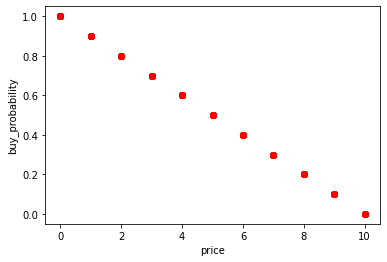

In [533]:
plt.plot(movie_data['price'].values, movie_data['buy_probability'].values, 'ro') # ro = red circles
plt.xlabel('price')
plt.ylabel('buy_probability')
plt.show()

## Genres distribution

In [534]:
def plot_genres(movie_data):
    genres_array = [(genre, movie_data[genre].sum()) for genre in genres_data['name'].values]
    genres_names = list(map(lambda x: x[0], genres_array))
    genres_count = list(map(lambda x: x[1], genres_array))

    genres_df = pd.DataFrame({'name': genres_names, 'count': genres_count})
    x = np.arange(len(genres_df['name'].values))
    plt.bar(x, genres_df['count'].values)
    plt.xticks(x, genres_df['name'].values, rotation='vertical')
    plt.title("Genres distribution")
    
def plot_years(movie_data):
    years = movie_data['release_date'].values.astype('datetime64[Y]').astype(int) + 1970
    plt.hist(years)
    plt.title("Years distribution")
    
def plot_ratings(movie_data):
    movie_data['ratings_average'].hist()
    plt.title("Ratings distribution")
    
def plot_price(movie_data):
    movie_data['price'].hist()
    plt.title("Price distribution")
    
def plot_ratings_count(movie_data):
    movie_data['ratings_count'].hist()
    plt.title("Ratings count")
    
def buy_probability_distribution(movie_data):
    movie_data['buy_probability'].hist(bins=11)
    plt.title("Buy probability distribution")

In [535]:
def plot_distributions(movie_data):
    fig = plt.figure(figsize=(8, 6)) 

    fig.add_subplot(3, 2, 1)
    plot_genres(movie_data)

    fig.add_subplot(3, 2, 2)
    plot_years(movie_data)

    fig.add_subplot(3, 2, 3)
    plot_ratings(movie_data)

    fig.add_subplot(3, 2, 4)
    plot_price(movie_data)

    fig.add_subplot(3, 2, 5)
    plot_ratings_count(movie_data)

    fig.add_subplot(3, 2, 6)
    buy_probability_distribution(movie_data)

    plt.tight_layout()

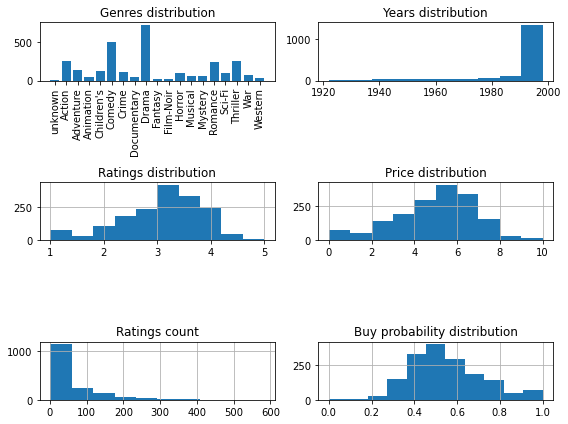

In [536]:
plot_distributions(movie_data)

# Events database functions

In [537]:
# The users database
class User:
    def __init__(self, id):
        self.id = id
        self.positive = []
        self.negative = []
        
    def add_positive(self, movie_id):
        self.positive.append(movie_id)
    
    def add_negative(self, movie_id):
        self.negative.append(movie_id)
    
    def get_positive(self):
        return self.positive
    
    def get_negative(self):
        return self.negative

In [538]:
np.random.seed(1)

class EventsGenerator:
    NUM_OF_OPENED_MOVIES_PER_USER = 20
    NUM_OF_USERS = 1000

    def __init__(self, learning_data, buy_probability):
        self.learning_data = learning_data
        self.buy_probability = buy_probability
        self.users = []
        for id in range(1, self.NUM_OF_USERS):
            self.users.append(User(id))
        
    def run(self, pairwise=False):
        for user in self.users:
            opened_movies = np.random.choice(self.learning_data.index.values, self.NUM_OF_OPENED_MOVIES_PER_USER)
            self.__add_positives_and_negatives_to(user, opened_movies)

        if pairwise:
            return self.__build_pairwise_events_data()
        else:
            return self.__build_events_data()

    def __add_positives_and_negatives_to(self, user, opened_movies):
        for movie_id in opened_movies:
            if np.random.binomial(1, self.buy_probability.loc[movie_id]): 
                user.add_positive(movie_id)
            else:
                user.add_negative(movie_id)
                
    def __build_events_data(self):
        events_data = []
        
        for user in self.users:
            for positive_id in user.get_positive():
                tmp = learning_data.loc[positive_id].to_dict()
                tmp['outcome'] = 1
                events_data += [tmp]
            
            for negative_id in user.get_negative():
                tmp = learning_data.loc[negative_id].to_dict()
                tmp['outcome'] = 0
                events_data += [tmp]
                
        return pd.DataFrame(events_data)
    
    def __build_pairwise_events_data(self):
        events_data = []
        
        for i, user in enumerate(self.users):
            print("{} of {}".format(i, len(self.users)))
            positives = user.get_positive()
            negatives = user.get_negative()
            
            sample_size = min(len(positives), len(negatives))
            
            positives = np.random.choice(positives, sample_size)
            negatives = np.random.choice(negatives, sample_size)
            
            # print("Adding {} events".format(str(len(positives) * len(negatives) * 2)))
            for positive in positives:
                for negative in negatives:                    
                    e1 = learning_data.loc[positive].values
                    e2 = learning_data.loc[negative].values
                    
                    pos_neg_example = np.concatenate([e1, e2, [1]])
                    neg_pos_example = np.concatenate([e2, e1, [0]])
                    
                    events_data.append(pos_neg_example)
                    events_data.append(neg_pos_example)
        
        c1 = [ c + '_1' for c in learning_data.columns]
        c2 = [ c + '_2' for c in learning_data.columns]
        return pd.DataFrame(events_data, columns = np.concatenate([c1, c2, ['outcome']]))

In [539]:
def build_learning_data_from(movie_data):
    feature_columns = np.setdiff1d(movie_data.columns, np.array(['title', 'buy_probability']))
    learning_data = movie_data.loc[:, feature_columns]
    
    scaler = StandardScaler()
    learning_data.loc[:, ('price')] = scaler.fit_transform(learning_data[['price']])
    learning_data['ratings_average'] = scaler.fit_transform(learning_data[['ratings_average']])
    learning_data['ratings_count'] = scaler.fit_transform(learning_data[['ratings_count']])
    learning_data['release_date'] = learning_data['release_date'].apply(lambda x: x.year)
    learning_data['release_date'] = scaler.fit_transform(learning_data[['release_date']])
    
    return learning_data

In [540]:
def plot_events_distribution(events_data):
    events_data_sample = events_data.sample(frac=0.1)
    negative_outcomes = events_data_sample[events_data_sample['outcome'] == 0.0]['price']
    positive_outcomes = events_data_sample[events_data_sample['outcome'] == 1.0]['price']
    
    outcomes = np.array(list(zip(negative_outcomes.values, positive_outcomes.values)))
    plt.hist(outcomes, bins=11, label = ['Negative', 'Positive'])
    plt.legend()
    plt.xlabel('price')
    plt.show()

In [541]:
def get_feature_columns_from(learning_data, pairwise=False):
    if not pairwise:
        return learning_data.columns.values
    else:
        f1 = [c + '_1' for c in learning_data.columns.values]
        f2 = [c + '_2' for c in learning_data.columns.values]
        f1.extend(f2)
        return np.asarray(f1)

In [542]:
def save_events_data(events_data, learning_data, tag, pairwise=False):
    events_data = events_data.reindex(np.random.permutation(events_data.index))
    events_data.to_csv('movie_events_' + tag + '.csv')
    
    if not pairwise:
        df = pd.DataFrame(get_feature_columns_from(learning_data))
        df.to_csv("feature_columns_" + tag + ".csv")
    else:
        df = pd.DataFrame(get_feature_columns_from(learning_data, pairwise=True))
        df.to_csv("feature_columns_" + tag + ".csv")

In [543]:
def load_events_data(tag):
    print('movie_events_' + tag + '.csv')
    events_data = pd.read_csv('movie_events_' + tag + '.csv')
    tmp = pd.read_csv("feature_columns_" + tag + ".csv")
    feature_columns = tmp['0'].values
    
    return [events_data, feature_columns]

In [544]:
def get_test_train_data(events_data, feature_columns):
    X = events_data.loc[:, feature_columns].values.astype(np.float32)
    print('overall input shape: ' + str(X.shape))

    y = events_data.loc[:, ['outcome']].values.astype(np.float32).ravel()
    print('overall output shape: ' + str(y.shape))

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print('training input shape: ' + str(X_train.shape))
    print('training output shape: ' + str(y_train.shape))

    print('testing input shape: ' + str(X_test.shape))
    print('testing output shape: ' + str(y_test.shape))
    
    return [X_train, X_test, y_train, y_test]

# Generate linear events

In [545]:

learning_data = build_learning_data_from(movie_data)

In [546]:
movie_data.head()


,title,release_date,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Mystery,Romance,Sci-Fi,Thriller,War,Western,ratings_average,ratings_count,price,buy_probability
movie_id,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),1995-01-01,0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,3.878319,452,7.0,0.3
2,GoldenEye (1995),1995-01-01,0,1,1,0,0,0,0,0,...,0,0,0,1,0,0,3.206107,131,5.0,0.5
3,Four Rooms (1995),1995-01-01,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,3.033333,90,5.0,0.5
4,Get Shorty (1995),1995-01-01,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,3.550239,209,6.0,0.4
5,Copycat (1995),1995-01-01,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,3.302326,86,5.0,0.5


In [547]:
learning_data.head()

,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,...,Romance,Sci-Fi,Thriller,War,Western,price,ratings_average,ratings_count,release_date,unknown
movie_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,1,1,1,0,0,0,0,0,...,0,0,0,0,0,1.344357,1.026718,4.883605,0.393978,0
2,1,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0.283637,0.166684,0.889797,0.393978,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0.283637,-0.054365,0.379685,0.393978,0
4,1,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0.813997,0.606970,1.860255,0.393978,0
5,0,0,0,0,0,1,0,1,0,0,...,0,0,1,0,0,0.283637,0.289787,0.329918,0.393978,0


In [548]:
events_data = EventsGenerator(learning_data, movie_data['buy_probability']).run()


In [549]:
events_data.head()

,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,...,Sci-Fi,Thriller,War,Western,price,ratings_average,ratings_count,release_date,unknown,outcome
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-1.307443,-1.376422,-0.715191,0.534335,0.0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-2.368163,-2.655833,-0.727633,0.604514,0.0,1
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.246723,-0.459109,-0.080661,0.043084,0.0,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.283637,0.069868,-0.453914,0.253620,0.0,1
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,-0.777083,1.108383,0.765380,-2.483349,0.0,1


In [550]:
save_events_data(events_data, learning_data, 'linear')

In [551]:
#events_data, feature_columns = load_events_data('linear')
levents_data, feature_columns = load_events_data('linear')
levents_data.head()

movie_events_linear.csv


,Unnamed: 0,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,...,Sci-Fi,Thriller,War,Western,price,ratings_average,ratings_count,release_date,unknown,outcome
0,10674,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.283637,0.169532,-0.142869,0.393978,0.0,0
1,13705,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.283637,-0.097012,-0.715191,0.393978,0.0,1
2,10621,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,-0.777083,-1.056570,-0.690307,0.253620,0.0,1
3,12469,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.246723,-0.416864,-0.690307,0.393978,0.0,1
4,11538,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.344357,1.138281,-0.379263,0.464156,0.0,0


In [557]:
feature_columns.shape

(23,)

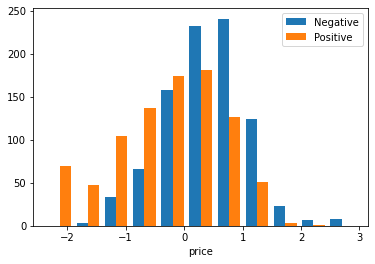

In [427]:
plot_events_distribution(events_data)

## Pairwise

In [214]:
#events_data = EventsGenerator(learning_data, movie_data['buy_probability']).run(pairwise=True)

0 of 999
1 of 999
2 of 999
3 of 999
4 of 999
5 of 999
6 of 999
7 of 999
8 of 999
9 of 999
10 of 999
11 of 999
12 of 999
13 of 999
14 of 999
15 of 999
16 of 999
17 of 999
18 of 999
19 of 999
20 of 999
21 of 999
22 of 999
23 of 999
24 of 999
25 of 999
26 of 999
27 of 999
28 of 999
29 of 999
30 of 999
31 of 999
32 of 999
33 of 999
34 of 999
35 of 999
36 of 999
37 of 999
38 of 999
39 of 999
40 of 999
41 of 999
42 of 999
43 of 999
44 of 999
45 of 999
46 of 999
47 of 999
48 of 999
49 of 999
50 of 999
51 of 999
52 of 999
53 of 999
54 of 999
55 of 999
56 of 999
57 of 999
58 of 999
59 of 999
60 of 999
61 of 999
62 of 999
63 of 999
64 of 999
65 of 999
66 of 999
67 of 999
68 of 999
69 of 999
70 of 999
71 of 999
72 of 999
73 of 999
74 of 999
75 of 999
76 of 999
77 of 999
78 of 999
79 of 999
80 of 999
81 of 999
82 of 999
83 of 999
84 of 999
85 of 999
86 of 999
87 of 999
88 of 999
89 of 999
90 of 999
91 of 999
92 of 999
93 of 999
94 of 999
95 of 999
96 of 999
97 of 999
98 of 999
99 of 999
100 of 999

756 of 999
757 of 999
758 of 999
759 of 999
760 of 999
761 of 999
762 of 999
763 of 999
764 of 999
765 of 999
766 of 999
767 of 999
768 of 999
769 of 999
770 of 999
771 of 999
772 of 999
773 of 999
774 of 999
775 of 999
776 of 999
777 of 999
778 of 999
779 of 999
780 of 999
781 of 999
782 of 999
783 of 999
784 of 999
785 of 999
786 of 999
787 of 999
788 of 999
789 of 999
790 of 999
791 of 999
792 of 999
793 of 999
794 of 999
795 of 999
796 of 999
797 of 999
798 of 999
799 of 999
800 of 999
801 of 999
802 of 999
803 of 999
804 of 999
805 of 999
806 of 999
807 of 999
808 of 999
809 of 999
810 of 999
811 of 999
812 of 999
813 of 999
814 of 999
815 of 999
816 of 999
817 of 999
818 of 999
819 of 999
820 of 999
821 of 999
822 of 999
823 of 999
824 of 999
825 of 999
826 of 999
827 of 999
828 of 999
829 of 999
830 of 999
831 of 999
832 of 999
833 of 999
834 of 999
835 of 999
836 of 999
837 of 999
838 of 999
839 of 999
840 of 999
841 of 999
842 of 999
843 of 999
844 of 999
845 of 999
846 of 999

In [215]:
#save_events_data(events_data, learning_data, 'pairwise-linear', pairwise=True)

In [553]:
#events_data, feature_columns = load_events_data('pairwise-linear')
#pairwise_events_data, feature_columns = load_events_data('pairwise-linear')


# Train/Test data split

In [555]:
#X_train, X_test, y_train, y_test = get_test_train_data(events_data, feature_columns)

train_size=0.8
X = levents_data.loc[:, feature_columns].values.astype(np.float32)
print('X Type: ' + str(type(X)))
print('overall input shape: ' + str(X.shape))

y = levents_data.loc[:, ['outcome']].values.astype(np.float32).ravel()
print('overall output shape: ' + str(y.shape))

# In the first step we will split the data in training and remaining dataset
X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.8)



# Now since we want the valid and test size to be equal (10% each of overall data). 
# we have to define valid_size=0.5 (that is 50% of remaining data)
test_size = 0.5
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5)

print('overall output shape: ' + str(X_train.shape))
print('overall output shape: ' + str(y_train.shape))
print('overall output shape: ' + str(X_rem.shape))
print('overall output shape: ' + str(y_rem.shape))
print('overall output shape: ' + str(X_valid.shape))
print('overall output shape: ' + str(y_valid.shape))
print('overall output shape: ' + str(X_test.shape))
print('overall output shape: ' + str(y_test.shape))


X Type: <class 'numpy.ndarray'>
overall input shape: (19980, 23)
overall output shape: (19980,)
overall output shape: (15984, 23)
overall output shape: (15984,)
overall output shape: (3996, 23)
overall output shape: (3996,)
overall output shape: (1998, 23)
overall output shape: (1998,)
overall output shape: (1998, 23)
overall output shape: (1998,)


In [556]:
X.shape

(19980, 23)

# Utility functions

In [504]:
def plot_rank(features, model, learning_data, predict_fun):
    lg_input = learning_data.values.astype(np.float32)
    print('overall input shape: ' + str(lg_input.shape))
    print('overall input type: ' + str(type(lg_input)))
    
    learning_data_with_rank = learning_data.copy()
    learning_data_with_rank['rank'] = predict_fun(model, lg_input)
    
    for idx, feature in enumerate(features):
        plt.subplot(len(features), 1, idx + 1)
        plt.plot(learning_data_with_rank[feature].values, learning_data_with_rank['rank'].values, 'ro')
        plt.xlabel(feature)
        plt.ylabel('rank')
        
    plt.tight_layout()
    plt.show()

In [500]:
def train_model(feature_columns,model, prediction_function, X_train, y_train, X_valid,y_valid, X_test, y_test):
    model.fit(X_train, y_train)
    
    y_train_predictions = prediction_function(model, X_train)
    training_dataset = pd.DataFrame(X_train,columns=feature_columns)
    training_dataset['Actual'] = y_train
    training_dataset['No_MoviePurchase_prob'] = y_train_predictions[:,0]
    training_dataset['Yes_MoviePurchase_prob'] = y_train_predictions[:,1]
    training_dataset['PurchasePrediction'] = np.argmax(y_train_predictions, axis=1).astype(np.float32)
    
    print(type(training_dataset['PurchasePrediction']))
    y_train_pred = np.argmax(y_train_predictions, axis=1).astype(np.float32)
    
    
#    return np.argmax(model.predict_proba(data), axis=1).astype(np.float32)
#    return model.predict_proba(data)

    print('train precision: ' + str(precision_score(y_train, training_dataset['PurchasePrediction'])))
    print('train recall: ' + str(recall_score(y_train, training_dataset['PurchasePrediction'])))
    print('train accuracy: ' + str(accuracy_score(y_train, training_dataset['PurchasePrediction'])))

#Validation set
    y_valid_predictions = prediction_function(model, X_valid)
    validation_dataset = pd.DataFrame(X_valid,columns=feature_columns)
    validation_dataset['Actual'] = y_valid
    validation_dataset['No_MoviePurchase_prob'] = y_valid_predictions[:,0]
    validation_dataset['Yes_MoviePurchase_prob'] = y_valid_predictions[:,1]
    validation_dataset['PurchasePrediction'] = np.argmax(y_valid_predictions, axis=1).astype(np.float32)    
    
    
    y_valid_pred = np.argmax(y_valid_predictions, axis=1).astype(np.float32)

    
    print('validation precision: ' + str(precision_score(y_valid, validation_dataset['PurchasePrediction'])))
    print('validation recall: ' + str(recall_score(y_valid, validation_dataset['PurchasePrediction'])))
    print('validation accuracy: ' + str(accuracy_score(y_valid, validation_dataset['PurchasePrediction'])))

#Test set
    y_test_predictions = prediction_function(model, X_test)
    test_dataset = pd.DataFrame(X_test,columns=feature_columns)
    test_dataset['Actual'] = y_test
    test_dataset['No_MoviePurchase_prob'] = y_test_predictions[:,0]
    test_dataset['Yes_MoviePurchase_prob'] = y_test_predictions[:,1]
    test_dataset['PurchasePrediction'] = np.argmax(y_test_predictions, axis=1).astype(np.float32)    
    
    
    y_test_pred = np.argmax(y_test_predictions, axis=1).astype(np.float32)

    
    print('test precision: ' + str(precision_score(y_test, test_dataset['PurchasePrediction'])))
    print('test recall: ' + str(recall_score(y_test, test_dataset['PurchasePrediction'])))
    print('test accuracy: ' + str(accuracy_score(y_test, test_dataset['PurchasePrediction'])))
   
    return model, training_dataset, validation_dataset,test_dataset

# Rank with a Logistic Regression

* Collect for each movie the buy probability from the raw events
* Run a beta regression

=> Expect the coefficients to represent the artificial probability function

In [491]:
def get_predicted_outcome(model, data):
#    print(model.predict_proba(data))
#    print(np.argmax(model.predict_proba(data), axis=1).astype(np.float32))
#    return np.argmax(model.predict_proba(data), axis=1).astype(np.float32)
    return model.predict_proba(data)

In [452]:
def get_predicted_rank(model, data):
    print(model.predict_proba(data).shape)
    return model.predict_proba(data)[:, 1] 

In [501]:
model, training_dataset, validation_dataset,test_dataset = train_model(feature_columns,LogisticRegression(), get_predicted_outcome, X_train, y_train, X_valid,y_valid,X_test, y_test)

<class 'pandas.core.series.Series'>
train precision: 0.6724873096446701
train recall: 0.740194435132417
train accuracy: 0.6527152152152152
validation precision: 0.6741854636591479
validation recall: 0.719892952720785
validation accuracy: 0.6476476476476476
test precision: 0.691855583543241
test recall: 0.7292035398230089
test accuracy: 0.6631631631631631


In [503]:
print(training_dataset.shape)
print(validation_dataset.shape)
print(test_dataset.shape)
print(learning_data.shape)

(15984, 27)
(1998, 27)
(1998, 27)
(1681, 23)


overall input shape: (1681, 23)
overall input type: <class 'numpy.ndarray'>
(1681, 2)


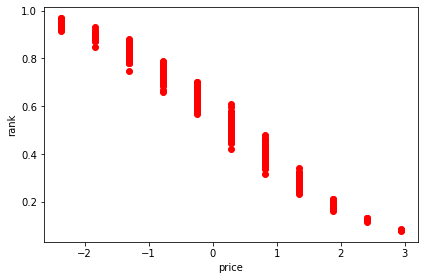

In [505]:
plot_rank(['price'], model, learning_data, get_predicted_rank)

# Rank with Decision Trees

In [506]:
#def get_predicted_outcome(model, data):
#    return np.argmax(model.predict_proba(data), axis=1).astype(np.float32)
def get_predicted_outcome(model, data):
#    print(model.predict_proba(data))
#    print(np.argmax(model.predict_proba(data), axis=1).astype(np.float32))
#    return np.argmax(model.predict_proba(data), axis=1).astype(np.float32)
    return model.predict_proba(data)

In [507]:
def get_predicted_rank(model, data):
    return model.predict_proba(data)[:, 1]

In [508]:
from sklearn import tree
#model = train_model(tree.DecisionTreeClassifier(), get_predicted_outcome, X_train, y_train, X_test, y_test)
model, training_dataset, validation_dataset,test_dataset = train_model(feature_columns,tree.DecisionTreeClassifier(), get_predicted_outcome, X_train, y_train, X_valid,y_valid,X_test, y_test)


<class 'pandas.core.series.Series'>
train precision: 0.7351979248900418
train recall: 0.72846128059001
train accuracy: 0.701076076076076
validation precision: 0.6627272727272727
validation recall: 0.6503122212310437
validation accuracy: 0.6181181181181181
test precision: 0.6679389312977099
test recall: 0.6194690265486725
test accuracy: 0.6106106106106106


overall input shape: (1681, 23)
overall input type: <class 'numpy.ndarray'>


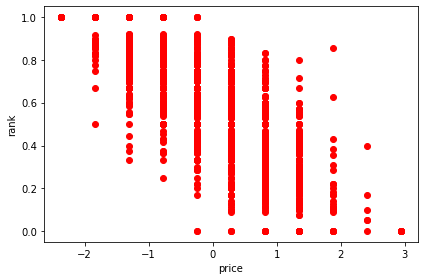

In [509]:
plot_rank(['price'], model, learning_data, get_predicted_rank)

# Customers with non-linear buying behaviour

In [100]:
price_component = np.sqrt(movie_data['price'] * 0.1)
ratings_component = np.sqrt(movie_data['ratings_average'] * 0.1 * 2)
movie_data['buy_probability'] = 1 - price_component * 0.2 - ratings_component * 0.8

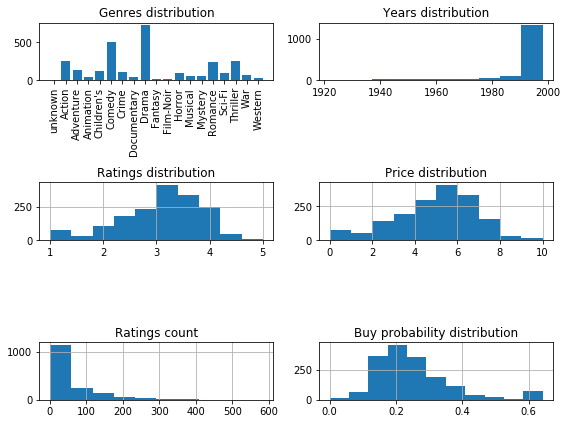

In [101]:
plot_distributions(movie_data)

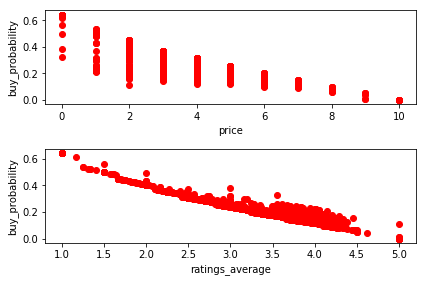

In [102]:
plt.subplot(2, 1, 1)
plt.plot(movie_data['price'].values, movie_data['buy_probability'].values, 'ro') # ro = red circles
plt.xlabel('price')
plt.ylabel('buy_probability')

plt.subplot(2, 1, 2)
plt.plot(movie_data['ratings_average'].values, movie_data['buy_probability'].values, 'ro') # ro = red circles
plt.xlabel('ratings_average')
plt.ylabel('buy_probability')

plt.tight_layout()
plt.show()

# Create events

In [103]:
learning_data = build_learning_data_from(movie_data)

In [69]:
positive_events, negative_events = generate_events()
events_data = build_events_data(positive_events, negative_events, learning_data)
save_events_data(events_data, learning_data, 'nonlinear')

In [104]:
events_data, feature_columns = load_events_data('nonlinear')

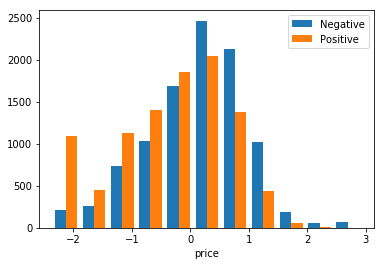

In [105]:
plot_events_distribution(events_data)

In [106]:
X_train, X_test, y_train, y_test = get_test_train_data(events_data)

overall input shape: (399980, 23)
overall output shape: (399980,)
training input shape: (319984, 23)
training output shape: (319984,)
testing input shape: (79996, 23)
testing output shape: (79996,)


# Rank with the perfect predictor

In [124]:
def get_predicted_outcome(model, data):
    return np.rint(model.predict(data))

In [125]:
def get_predicted_rank(model, data):
    return model.predict(data)

In [126]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [127]:
class PerfectPredictor:
    def fit(self, X, y):
        return None
    
    def predict(self, X):
        min_max_scaler = preprocessing.MinMaxScaler()
        price_component = np.sqrt(min_max_scaler.fit_transform(X[:, -5]))
        ratings_component = np.sqrt(min_max_scaler.fit_transform(X[:, -4]))
        return 1 - price_component * 0.2 - ratings_component * 0.8

train precision: 0.515083321464
train recall: 0.226469446288
train accuracy: 0.753787689384
test precision: 0.513203730756
test recall: 0.228281515545
test accuracy: 0.752850142507
overall input shape: (1681, 23)


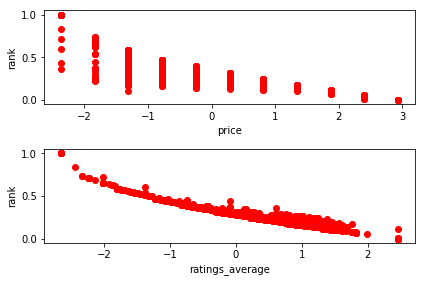

In [128]:
model = train_model(PerfectPredictor(), get_predicted_outcome, X_train, y_train, X_test, y_test)
plot_rank(['price', 'ratings_average'], model, learning_data, get_predicted_rank)

# Rank with Logistic Regression

In [107]:
def get_predicted_outcome(model, data):
    return np.argmax(model.predict_proba(data), axis=1).astype(np.float32)

In [108]:
def get_predicted_rank(model, data):
    return model.predict_proba(data)[:, 1]

In [109]:
model = train_model(LogisticRegression(), get_predicted_outcome, X_train, y_train, X_test, y_test)

train precision: 0.613005193046
train recall: 0.136016933231
train accuracy: 0.762991274564
test precision: 0.605217010083
test recall: 0.138008597421
test accuracy: 0.761913095655


overall input shape: (1681, 23)


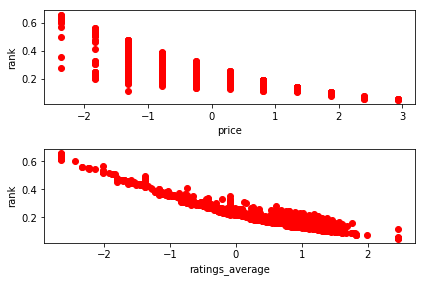

In [110]:
plot_rank(['price', 'ratings_average'], model, learning_data, get_predicted_rank)

# Rank with Neural Networks

In [33]:
def get_predicted_outcome(model, data):
    return np.rint(model.predict(data))

In [34]:
def get_predicted_rank(model, data):
    return model.predict(data)

In [ ]:
model = train_model(
    nn(), 
    get_predicted_outcome, 
    X_train.astype(np.float32), 
    y_train.astype(np.float32), 
    X_test.astype(np.float32), 
    y_test.astype(np.float32)
)

overall input shape: (1681, 23)


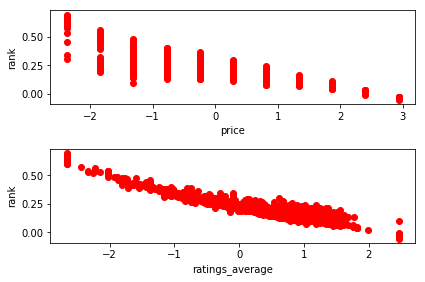

In [114]:
plot_rank(['price', 'ratings_average'], model, learning_data, get_predicted_rank)

# Rank with Decision Trees

In [115]:
def get_predicted_outcome(model, data):
    return np.argmax(model.predict_proba(data), axis=1).astype(np.float32)

In [116]:
def get_predicted_rank(model, data):
    return model.predict_proba(data)[:, 1]

In [117]:
from sklearn import tree
model = train_model(tree.DecisionTreeClassifier(), get_predicted_outcome, X_train, y_train, X_test, y_test)

train precision: 0.634287197456
train recall: 0.122427764488
train accuracy: 0.763413170659
test precision: 0.625315179022
test recall: 0.123962811157
test accuracy: 0.762338116906


overall input shape: (1681, 23)


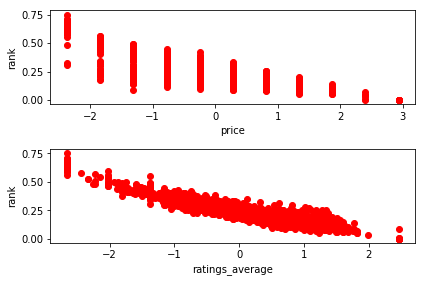

In [118]:
plot_rank(['price', 'ratings_average'], model, learning_data, get_predicted_rank)

# Pairwise learning

In [95]:
def nn():
    return NeuralNet(
        layers=[  # three layers: one hidden layer
            ('input', layers.InputLayer),
            ('hidden', layers.DenseLayer),
            ('output', layers.DenseLayer),
            ],
        # layer parameters:
        input_shape=(None, 46),  # this code won't compile without SIZE being set
        hidden_num_units=92,  # number of units in hidden layer
        output_nonlinearity=None,  # output layer uses identity function
        output_num_units=1,  # this code won't compile without OUTPUTS being set

        # optimization method:
        update_learning_rate=0.01, 
        regression=True,  # If you're doing classification you want this off
        max_epochs=50,  # more epochs can be good, 
        verbose=1, # enabled so that you see meaningful output when the program runs
    )

In [96]:
def get_predicted_outcome(model, data):
    return np.rint(model.predict(data))

In [97]:
def plot_rank_for_pairwise(features, model, learning_data, predict_fun):
    learning_data_with_rank = learning_data.copy()
    learning_data_with_rank = predict_fun(model, learning_data_with_rank)
    
    for idx, feature in enumerate(features):
        plt.subplot(len(features), 1, idx + 1)
        plt.plot(learning_data_with_rank[feature].values, learning_data_with_rank['rank'].values, 'ro')
        plt.xlabel(feature)
        plt.ylabel('rank')
        
    plt.tight_layout()
    plt.show()

In [98]:
def get_predicted_rank(model, data):
    cached_preference = {}

    def preference(x, y):
        if cached_preference.get((x, y)) is not None:
            return cached_preference[x, y]
        
        x_v = data.loc[x].values
        y_v = data.loc[y].values
        cached_preference[x, y] = model.predict(np.array([np.concatenate([x_v, y_v])]))
        return cached_preference[x, y]
        
    g = GreedyOrder(data.index, preference)
    order = g.run()
    for i, row in data.iterrows():
        data.loc[i, 'rank'] = 1 - (order.index(i) / float(len(order)))
    
    return data

In [99]:
from importlib import reload
import greedy_order
reload(greedy_order)
from greedy_order import *

In [100]:
model = train_model(
    nn(), 
    get_predicted_outcome, 
    X_train.astype(np.float32), 
    y_train.astype(np.float32), 
    X_test.astype(np.float32), 
    y_test.astype(np.float32)
)

# Neural Network with 4417 learnable parameters

## Layer information

  #  name      size
---  ------  ------
  0  input       46
  1  hidden      92
  2  output       1

  epoch    trn loss    val loss    trn/val  dur
-------  ----------  ----------  ---------  -----
      1     0.19161     0.18387    1.04211  0.77s
      2     0.18166     0.18241    0.99589  0.77s
      3     0.18035     0.18143    0.99405  0.96s
      4     0.17941     0.18067    0.99303  0.91s
      5     0.17860     0.18007    0.99183  0.99s
      6     0.17784     0.17954    0.99054  0.87s
      7     0.17716     0.17910    0.98915  0.94s
      8     0.17651     0.17870    0.98777  0.97s
      9     0.17589     0.17835    0.98625  1.01s
     10     0.17532     0.17801    0.98488  0.96s
     11     0.17478     0.17782    0.98287  0.91s
     12     0.17427     0.17758    0.98133  0.81s
     13     0.17377     0.17730    0.98012  0.89s
     14     0.17330     0.17707    0.97872  0.88s
     15     0.17284     0.1767

/Users/motta/.pyenv/versions/learning-to-rank/lib/python3.5/site-packages/sklearn/metrics/classification.py:1076: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


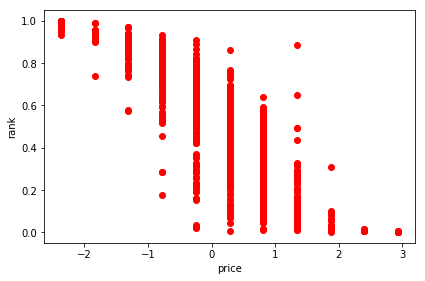

In [101]:
plot_rank_for_pairwise(['price'], model, learning_data, get_predicted_rank)